# Computing window matrices with autodiff

The window matrix $\mathrm{W}$ relates the (mean) observed power spectrum $\langle P_o \rangle$
to the power spectrum theory $P_t$: $\langle P_o \rangle = \mathrm{W} P_t$.
In other words, it is just the Jacobian of $\langle P_o \rangle$ w.r.t. $P_t$... which we can hope to compute with autodiff!

In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import jax
from jax import numpy as jnp
from jax import random

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 4)

from jpower import GaussianField, SurveySelection, BoxFFTPower, SurveyFFTPower, utils

## Trivial example: box power spectrum

Let's start with the window for the power spectrum of a simulation box. Let's consider the following pipeline, with input the theory power spectrum $P_i$ and output the measured power spectrum $P_o$:

1. generate a Gaussian random field following $P_i$
2. compute the power spectrum of that random field to obtain $P_o$

Then, we take the derivative of $P_o$ w.r.t. $P_i$. Of course, 1) and 2) must be differentiable.

In [2]:
def mock_box(power, unitary_amplitude=False, boxsize=1000., meshsize=128, **kwargs):
    # 1. Generate Gaussian random field 1000^3 (Mpc/h)^3 with 128^3 cells
    field = GaussianField(power, unitary_amplitude=unitary_amplitude, boxsize=boxsize, meshsize=meshsize, **kwargs)
    edges = {'step': 0.01}
    # 2. Compute power spectrum
    return BoxFFTPower(field.density / jnp.mean(field.density) - 1., cellsize=field.cellsize, edges=edges, compensate=None)

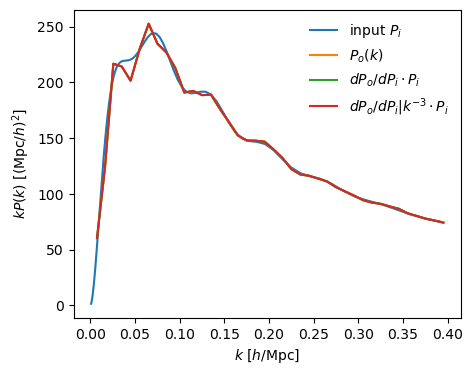

In [3]:
from cosmoprimo.fiducial import DESI
cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin)

get_pk = lambda pkin, **kwargs: mock_box(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])

seed = random.key(42)
# Get one power spectrum
pk = get_pk(pkin, seed=seed)
pkt = get_wmat(pkin, seed=seed).dot(pkin)
pkt_km3 = get_wmat(kin**(-3), seed=seed).dot(pkin)
k, edges = pk.k, pk.edges

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk.power, label='$P_o(k)$')
ax.plot(k, k * pkt, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

- blue: input power spectrum $P_i$
- orange: output power spectrum $P_o$
- green: Jacobian $dP_o/dP_i$, evaluated at $P_i$
- red: Jacobian $dP_o/dP_i$, evaluated at $k^{-3}$

The Jacobian does not depend on the input power spectrum, all good!
However, this is for one realization of the initial conditions...
To compute the window matrix, we must average!
In this case, we can just force the amplitude of the initial fluctuations to have unit variance (before product with the input power spectrum).

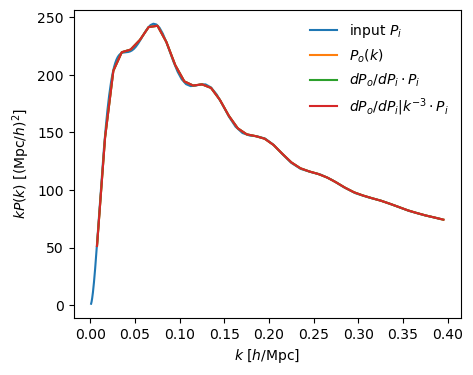

In [4]:
pk_unit = get_pk(pkin, seed=seed, unitary_amplitude=True)
seed = random.key(44)
pk_unit2 = get_pk(pkin, seed=seed, unitary_amplitude=True)
assert np.allclose(pk_unit2.power, pk_unit.power)  # no dependence on the seed with unitary_amplitude=True
pkt_unit = get_wmat(pkin, seed=seed, unitary_amplitude=True).dot(pkin)
pkt_km3_unit = get_wmat(kin**(-3), seed=seed, unitary_amplitude=True).dot(pkin)

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk_unit.power, label='$P_o(k)$')
ax.plot(k, k * pkt_unit, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3_unit, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

## Semi-realistic example: varying selection function

Let's implement a non-trivial survey selection function, e.g. $\bar{n}(x, y, z) \propto e^{-(x^2 + y^2 + z^2) / (0.2 L)}$, with $L = 2000 \, \mathrm{Mpc}/h$ the box size, truncated at the box boundaries.

In [5]:
def get_gaussian_survey_positions(boxsize=2000., meshsize=128, size=int(1e6), seed=random.key(42), scale=0.2):
    # Generate Gaussian-distributed positions
    positions = scale * boxsize * random.normal(seed, shape=(size, 3))
    # weights = 0. outside of the box extent
    mask = jnp.all((positions >= -boxsize / 2.) & (positions <= boxsize / 2.), axis=-1)
    weights = jnp.where(mask, 1., 0.)
    return positions, weights


def gaussian_survey(boxsize=2000., meshsize=128, size=int(1e6), seed=random.key(42), scale=0.2, **kwargs):
    positions, weights = get_gaussian_survey_positions(boxsize=boxsize, meshsize=meshsize, size=size, seed=seed, scale=scale)
    # Survey selection function, obtained by painting the above positions
    return SurveySelection(positions, weights=weights, boxcenter=0., boxsize=boxsize, meshsize=meshsize, **kwargs)


def mock_survey(power, selection, unitary_amplitude=True, norm=None, seed=random.key(42), **kwargs):
    # Generate Gaussian field
    field = GaussianField(power, boxsize=selection.boxsize, meshsize=selection.meshsize,
                          unitary_amplitude=unitary_amplitude, seed=seed, **kwargs)
    edges = {'step': 0.01}
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    return SurveyFFTPower(field.density * selection.density, selection.density, cellsize=field.cellsize, edges=edges, compensate=None, norm=norm)

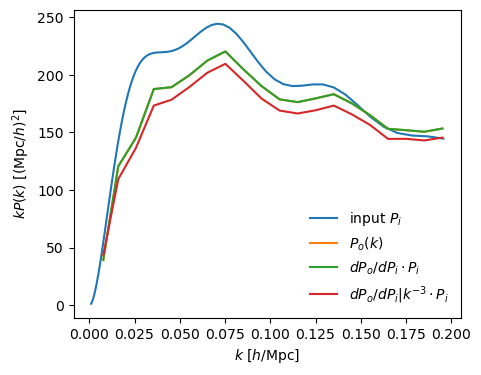

In [6]:
selection = gaussian_survey()

get_pk = lambda pkin, **kwargs: mock_survey(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), selection, **kwargs)
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])
# Same code as in the previous case!
seed = random.key(42)
# Get one power spectrum
pk = get_pk(pkin, seed=seed)
pkt = get_wmat(pkin, seed=seed).dot(pkin)
pkt_km3 = get_wmat(kin**(-3), seed=seed).dot(pkin)
k, edges = pk.k, pk.edges

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input $P_i$')
ax.plot(k, k * pk.power, label='$P_o(k)$')
ax.plot(k, k * pkt, label='$dP_o/dP_i \cdot P_i$')
ax.plot(k, k * pkt_km3, label='$dP_o/dP_i | k^{-3} \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Green is on top of orange, good. But woops, it looks like the derivative $dP_o/dP_i$ depends on the input power spectrum?
Let's try to average!

In [7]:
from tqdm import trange
pks, wmats, pkts, pkts_km3 = [], [], [], []
npk, npkt = 50, 50
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))
with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(pkin, seed=seed)
        wmats.append(wmat)
        pkts.append(wmat.dot(pkin))
        pkts_km3.append(get_wmat(kin**(-3), seed=seed).dot(pkin))

100%|██████████| 50/50 [03:10<00:00,  3.81s/it]


Note: on the GPU, it is 10 times faster, so computing window matrices for $\mathcal{O}(100)$ realizations should be largely feasible.

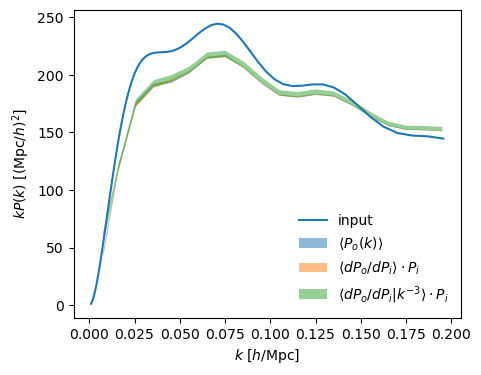

In [8]:
k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power for pk in pks], axis=0), np.std([pk.power for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5
pkt_km3_mean, pkt_km3_std = np.mean(pkts_km3, axis=0), np.std(pkts_km3, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.fill_between(k, k * (pkt_km3_mean - pkt_std), k * (pkt_km3_mean + pkt_km3_std), lw=0., alpha=0.5, label=r'$\langle dP_o/dP_i | k^{-3} \rangle \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

Looks all good!

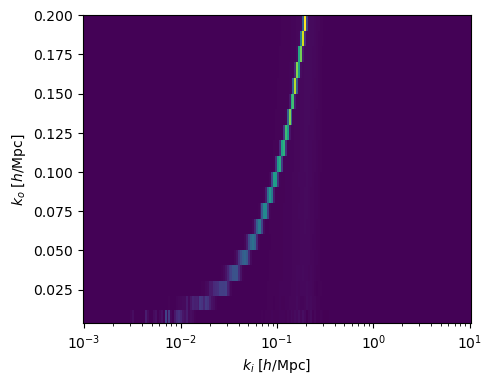

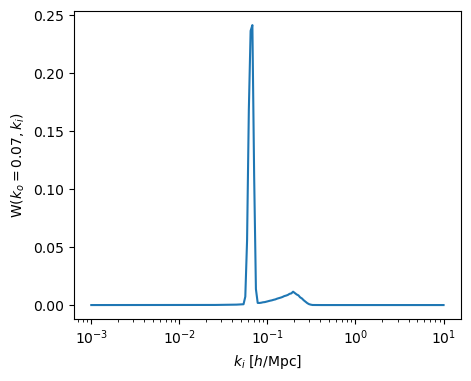

In [9]:
wmat = np.mean(wmats, axis=0)
ax = plt.gca()
ax.pcolormesh(kin, k, wmat)
ax.set_xscale('log')
ax.set_ylabel(r'$k_o$ [$h/\mathrm{Mpc}$]')
ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
plt.show()

ax = plt.gca()
ax.plot(kin, wmat[np.argmin(np.abs(k - 0.07))])
ax.set_xscale('log')
ax.set_xlabel(r'$k_i$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$\mathrm{W}(k_o=0.07, k_i)$')
plt.show()

Hm, there seems to be some non-zero contribution from $k_i \sim 0.2 \; h/\mathrm{Mpc}$ to all scales...

## Adding some shot noise
Instead of "meshes" as above, here we generate a Gaussian mock in terms of particle positions and weights... Just to check there is nothing crazy happening.

100%|██████████| 50/50 [16:20<00:00, 19.62s/it]


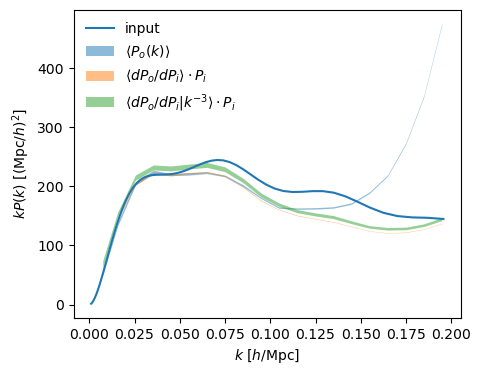

In [10]:
def mock_survey_noise(power, boxsize=2000., meshsize=128, size=int(1e6), seed=random.key(42), scale=0.2, unitary_amplitude=True, norm=None):
    # Generate Gaussian field
    seeds = random.split(seed, 3)
    shotnoise_nonorm = 0.
    # randoms
    positions, weights = get_gaussian_survey_positions(boxsize=boxsize, meshsize=meshsize, size=size, seed=seeds[0], scale=scale)
    shotnoise_nonorm += jnp.sum(weights**2)
    randoms = SurveySelection(positions, weights, boxcenter=0., boxsize=boxsize, meshsize=meshsize)
    # field
    field = GaussianField(power, boxsize=randoms.boxsize, meshsize=randoms.meshsize,
                          unitary_amplitude=unitary_amplitude, seed=seeds[1])
    positions, weights = get_gaussian_survey_positions(boxsize=boxsize, meshsize=meshsize, size=size, seed=seeds[2], scale=scale)
    # data
    shotnoise_nonorm += jnp.sum(weights**2)
    weights *= field.read(positions)  # multiply by 1 + delta
    data = SurveySelection(positions, weights, boxcenter=0., boxsize=boxsize, meshsize=meshsize)
    edges = {'step': 0.01}
    # Multiply Gaussian field with survey selection function, then compute power spectrum
    return SurveyFFTPower(data.density, randoms.density, cellsize=field.cellsize, edges=edges, compensate='cic', norm=norm, shotnoise_nonorm=shotnoise_nonorm)


from cosmoprimo.fiducial import DESI
cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)
kin = jnp.geomspace(1e-3, 1e1, 200)
pkin = pk(kin)
get_pk = lambda pkin, **kwargs: mock_survey_noise(lambda k: jnp.interp(k, kin, pkin, left=0., right=0.), **kwargs)
# Below is same code as above
get_wmat = lambda pkin, **kwargs: jax.jacrev(lambda pkin: get_pk(pkin, **kwargs).power)(pkin)
get_pk = jax.jit(get_pk, static_argnames=['unitary_amplitude'])
get_wmat = jax.jit(get_wmat, static_argnames=['unitary_amplitude'])

from tqdm import trange
pks, wmats, pkts, pkts_km3 = [], [], [], []
npk, npkt = 50, 50
with trange(npk) as t:
    for imock in t:
        seed = random.key(2 * imock)
        pks.append(get_pk(pkin, seed=seed))

with trange(npkt) as t:
    for imock in t:
        # Here we do not use the same seeds
        seed = random.key(2 * imock + 1)
        wmat = get_wmat(pkin, seed=seed)
        wmats.append(wmat)
        pkts.append(wmat.dot(pkin))
        pkts_km3.append(get_wmat(kin**(-3), seed=seed).dot(pkin))

k, edges = pks[0].k, pks[0].edges
pk_mean, pk_std = np.mean([pk.power for pk in pks], axis=0), np.std([pk.power for pk in pks], axis=0) / npk**0.5
pkt_mean, pkt_std = np.mean(pkts, axis=0), np.std(pkts, axis=0) / npkt**0.5
pkt_km3_mean, pkt_km3_std = np.mean(pkts_km3, axis=0), np.std(pkts_km3, axis=0) / npkt**0.5

ax = plt.gca()
maskin = kin < edges[-1]
ax.plot(kin[maskin], kin[maskin] * pkin[maskin], label='input')
kw = dict(lw=0., alpha=0.5)
ax.fill_between(k, k * (pk_mean - pk_std), k * (pk_mean + pk_std), label=r'$\langle P_o(k) \rangle$', **kw)
ax.fill_between(k, k * (pkt_mean - pkt_std), k * (pkt_mean + pkt_std), label=r'$\langle dP_o/dP_i \rangle \cdot P_i$', **kw)
ax.fill_between(k, k * (pkt_km3_mean - pkt_std), k * (pkt_km3_mean + pkt_km3_std), lw=0., alpha=0.5, label=r'$\langle dP_o/dP_i | k^{-3} \rangle \cdot P_i$')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend(frameon=False)
plt.show()

(If you are worried about the 20 s / iteration for the window matrix evluation... On a GPU node it takes 0.15 s / iteration.)

Again, the derivative $\langle dP_o/dP_i \rangle$ does not depend on where it is evaluated --- at first order. There is a bit of an offset in $\langle dP_o/dP_i | k^{-3} \rangle \cdot P_i$, though... Something to keep in mind to look at. The high-$k$ tail in the mean $\langle P_o(k) \rangle$ is probably due to shot noise that results in aliasing, not correctly mitigated by the CIC interpolation scheme.
That is traditionally corrected by interlacing, which we should implement, at least for completeness.
But we may also be able to obtain the corresponding "shot noise" window...